## Midterm BME 502 2025

In this midterm exam, you are tasked to develop a method to tell whether data is better described by a line fit or a sigmoidal fit.

In [77]:
import Pkg
Pkg.activate(".")

  Activating project at `c:\Users\Hasta\OneDrive\Documents\!!SBU BME (B.E.-M.S.)\BME 502 (Analy App Bio Syst)\BME-502-2025-homeworks`


In [78]:
Pkg.add(["Plots","Distributions","Random","Roots","Statistics","NonlinearSolve","LsqFit","ForwardDiff"])

   Resolving package versions...
  No Changes to `C:\Users\Hasta\OneDrive\Documents\!!SBU BME (B.E.-M.S.)\BME 502 (Analy App Bio Syst)\BME-502-2025-homeworks\Project.toml`
  No Changes to `C:\Users\Hasta\OneDrive\Documents\!!SBU BME (B.E.-M.S.)\BME 502 (Analy App Bio Syst)\BME-502-2025-homeworks\Manifest.toml`


In [79]:
using Plots, Distributions, Random, Roots, Statistics, NonlinearSolve, LsqFit, ForwardDiff, LinearAlgebra

In [80]:
line_fit(x,p) = p[1] .+ p[2] .* x

line_fit (generic function with 1 method)

In [81]:
sigmoid_fit(x,p) = p[1] .+ p[2] ./ (1 .+ exp.(-p[3]*(x .- p[4])))

sigmoid_fit (generic function with 1 method)

Let's create some plots to see how these functions look

In [82]:
x = 0:0.1:10

0.0:0.1:10.0

In [83]:
y_line = line_fit(x,[2,0.5])

2.0:0.05:7.0

In [84]:
y_sigmoid = sigmoid_fit(x,[2.5,3.5,0.1,5.5])

101-element Vector{Float64}:
 3.7805254314621974
 3.788656537923644
 3.796809108114118
 3.8049828179038157
 3.8131773393604975
 3.8213923407935093
 3.8296274867991844
 3.837882438307629
 3.8461568526308625
 3.854450383512326
 ⋮
 4.57010642451473
 4.5785558602695
 4.586989447538757
 4.595406810393582
 4.603807575969294
 4.612191374526542
 4.620557839511163
 4.6289066076128
 4.637237318822277

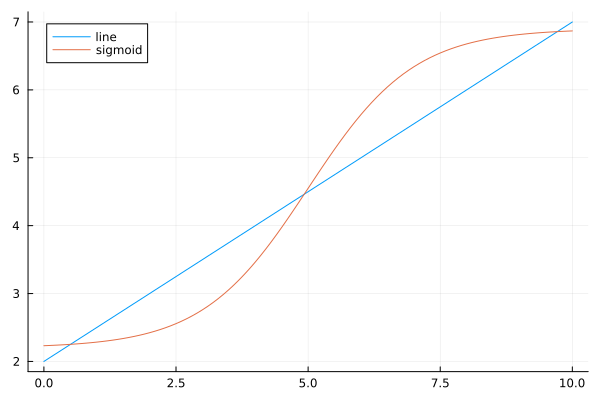

In [85]:
y_line = line_fit(x,[2,0.5])
y_sigmoid = sigmoid_fit(x,[2.2,4.7,1,5.0])
plot(x, y_line, label = "line")
plot!(x, y_sigmoid, label = "sigmoid")

Let us add some serious noise to it

In [86]:
nd = Normal(0,5)
x_line = 10*rand(200)
y_line_n = line_fit(x_line,[2,0.5]) .+ rand(nd,length(x_line))
x_sigmoid = 10*rand(200)
y_sigmoid_n = sigmoid_fit(x_sigmoid,[2.2,4.7,1,5.0]) .+ rand(nd,length(x_sigmoid))

200-element Vector{Float64}:
  5.549060972389211
  8.406707953061925
  6.92177582699065
  4.176031761819397
  3.4544095112308506
 15.545568252855443
  5.751982712570432
  8.01915922917852
 -2.1986294067361474
  0.488966204329929
  ⋮
  3.844323199719633
  4.488549180102775
  2.4989371816941377
  4.6947140864401
  6.577899389770316
  8.616954000158284
  6.169646098594361
  3.1776289485818285
  8.155404094231645

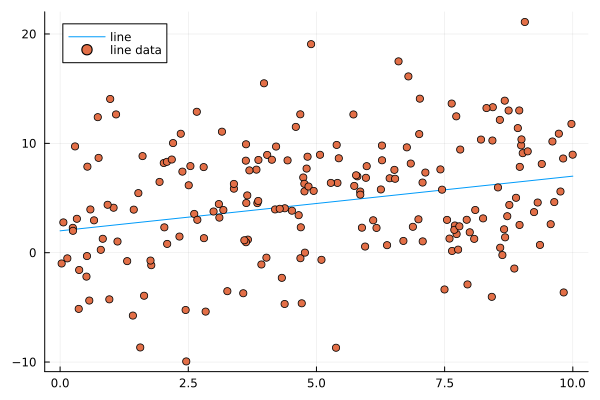

In [87]:
plot(x, y_line, label = "line")
scatter!(x_line, y_line_n, label = "line data")

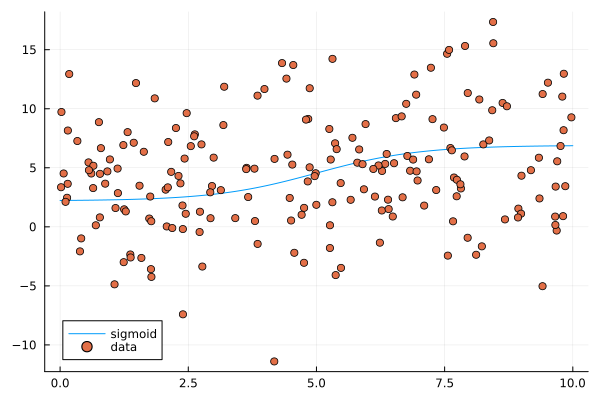

In [88]:
plot(x, y_sigmoid, label = "sigmoid")
scatter!(x_sigmoid, y_sigmoid_n, label = "data")

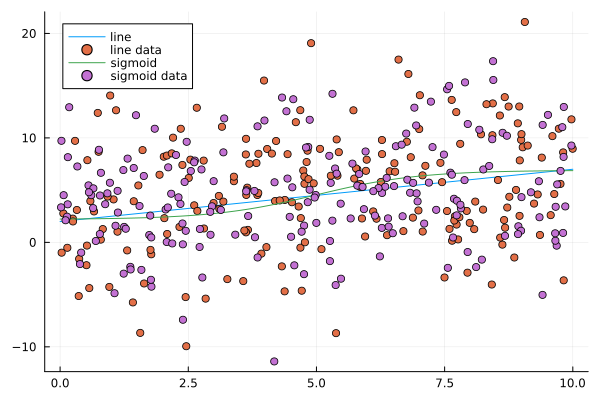

In [89]:
# let's plot it all together
plot(x, y_line, label = "line")
scatter!(x_line, y_line_n, label = "line data")
plot!(x, y_sigmoid, label = "sigmoid")
scatter!(x_sigmoid, y_sigmoid_n, label = "sigmoid data")

# Question:

If you take the sigmoid data, which fit is better? The linear or sigmoid?

How uncertain are the parameters?

At what noise level are the two fits equally likely?

# Part 1 (20 points)
Create a function line_fitting(x,y; sigma=[]) that returns the best parameters and the covariance matrix.  The standard deviation of the measurement error, sigma, can be supplied as a number (assuming that all measurements share the same error) or as a vector with the same length as y. If sigma (standard deviation of measurement error) is not specified (sigma=[]), estimate the measurement error using the sum of least squares to estimate $\mathcal{X}^2$.

In [90]:
# Define a simple linear model: y = intercept + slope * x
function line_model(x, p)
    intercept, slope = p
    return intercept .+ slope .* x
end

# Fit the linear model to data and estimate uncertainty in the parameters
function line_fitting(x, y; sigma=[], p0=[2.0, 0.5])
    # If no measurement error (sigma) is provided, estimate it from initial residuals
    if isempty(sigma)
        fit_tmp = curve_fit(line_model, x, y, p0)
        residuals = y .- line_model(x, fit_tmp.param)
        σ_est = std(residuals)
        sigma = fill(σ_est, length(x))  # Use a constant sigma for all data points
    elseif isa(sigma, Number)
        sigma = fill(sigma, length(x))  # Convert scalar sigma into an array
    end

    # Perform the actual curve fitting using the line model
    fit = curve_fit(line_model, x, y, p0)
    p_fit = fit.param

    # Define the chi-squared function to assess goodness-of-fit
    function chi_squared(p)
        residuals = (line_model(x, p) .- y) ./ sigma
        return sum(residuals .^ 2)
    end

    # Estimate the covariance matrix by inverting the Hessian of the chi-squared function
    cov_matrix = fill(NaN, length(p_fit), length(p_fit))  # Default NaN matrix in case of failure
    try
        H = ForwardDiff.hessian(chi_squared, p_fit)
        if all(isfinite, H)
            cov_matrix = inv(2 * H)  # Covariance approximation from Hessian
        end
    catch e
        @warn "Failed to compute Hessian: $e"
    end

    # Calculate final chi-squared value and a posterior likelihood-like metric
    chi2_val = chi_squared(p_fit)
    posterior_ratio = exp(-0.5 * chi2_val)

    return p_fit, cov_matrix, chi2_val, posterior_ratio
end

line_fitting (generic function with 1 method)

# Part 2 (20 points)
Similarily, create a function sigmoid_fitting(x,y; sigma=[]) that returns the best parameters and the covariance matrix. Treat sigma the same way as in Part 1.

In [91]:
# Define the sigmoid model: y = p1 + p2 / (1 + exp(-p3 * (x - p4)))
function sigmoid_model(x, p)
    p1, p2, p3, p4 = p
    return p1 .+ p2 ./ (1 .+ exp.(-p3 .* (x .- p4)))
end

# Fit the sigmoid model to data using non-linear least squares and estimate parameter uncertainty
function sigmoid_fitting(x, y; sigma=[], β0=[2.2, 4.7, 1.0, 5.0])
    # If sigma is not provided, estimate it from residuals of a preliminary fit
    if isempty(sigma)
        fit_tmp = curve_fit(sigmoid_model, x, y, β0)
        residuals = y .- sigmoid_model(x, fit_tmp.param)
        σ_est = std(residuals)
        sigma = fill(σ_est, length(x))  # Uniform uncertainty estimate
    elseif isa(sigma, Number)
        sigma = fill(sigma, length(x))  # Convert scalar to full-length array
    end

    # Perform the actual sigmoid fit
    fit = curve_fit(sigmoid_model, x, y, β0)
    p_fit = fit.param

    # Define chi-squared cost function for computing covariance
    function chi_squared(p)
        residuals = (sigmoid_model(x, p) .- y) ./ sigma
        return sum(residuals .^ 2)
    end

    # Initialize covariance matrix with NaNs in case Hessian fails
    cov_matrix = fill(NaN, length(p_fit), length(p_fit))
    try
        H = ForwardDiff.hessian(chi_squared, p_fit)
        if all(isfinite, H)
            cov_matrix = inv(2 * H)  # Approximate covariance matrix
        end
    catch e
        @warn "Failed to compute Hessian: $e"
    end

    # Compute final chi-squared and posterior ratio (likelihood-like metric)
    chi2_val = chi_squared(p_fit)
    posterior_ratio = exp(-0.5 * chi2_val)

    return p_fit, cov_matrix, chi2_val, posterior_ratio
end

sigmoid_fitting (generic function with 1 method)

# Part 3 (30 points)
Create a function p_ratio_sig_line(x,y; sigma=[]) that returns the Posterior ratio between a fit to a sigmoid and to a line.  Treat sigma the same way as in Part 1-2.

In [92]:
function p_ratio_sig_line(x, y; sigma=[])
    try
        # If sigma not provided, estimate it from the residuals of a line fit
        if isempty(sigma)
            line_params, _, line_chi2, _ = line_fitting(x, y)
            dof = length(x) - length(line_params)
            σ_est = sqrt(line_chi2 / dof)
            sigma = fill(σ_est, length(x))  # uniform measurement error
        elseif isa(sigma, Number)
            sigma = fill(sigma, length(x))  # convert scalar to vector
        end

        # Fit both models using the same sigma
        _, _, line_chi2, _ = line_fitting(x, y, sigma=sigma)
        _, _, sigmoid_chi2, _ = sigmoid_fitting(x, y, sigma=sigma)

        # Compute posterior ratio based on difference in chi-squared values
        Δχ² = line_chi2 - sigmoid_chi2
        return exp(Δχ² / 2)  # ratio > 1 → sigmoid fits better
    catch e
        @warn "Failed to compute posterior ratio: $e"
        return NaN
    end
end

p_ratio_sig_line (generic function with 1 method)

# Part 4 (30 points)
Create a function sig_p_ratio_is_one(x,y; sigma=[]) that returns the measurement error (either as a number or array depending on how the sigma is supplied) that would result in a posterior ratio between sigmoid and line of one. If sigma is not provided (sigma=[]), proceed as in Part 1-3.

In [93]:
function sig_p_ratio_is_one(x, y; sigma=[])
    tol = 1e-2
    max_iters = 100

    # Initialize sigma value
    σ_val = 1.0  # default starting guess

    # Override starting guess if sigma was a scalar
    if isa(sigma, Number)
        σ_val = sigma
    elseif isa(sigma, AbstractVector) && !isempty(sigma)
        σ_val = mean(sigma)
    elseif !isempty(sigma)
        error("sigma must be empty, a number, or a vector")
    end

    # Iterative search
    for i in 1:max_iters
        ratio = p_ratio_sig_line(x, y, sigma=fill(σ_val, length(x)))
        if abs(ratio - 1) < tol
            return σ_val
        elseif ratio > 1
            σ_val *= 1.1
        else
            σ_val *= 0.9
        end
    end

    @warn "Did not converge to posterior ratio = 1 within $max_iters iterations"
    return σ_val
end

sig_p_ratio_is_one (generic function with 1 method)

## Programming Advice:
To make your program more efficient you should think about creating functions that provide information that you can use for all of the parts.  Don't write each function individually, but think what are the common task that need to be done, and then call these more general functions, to get you the result for the specific questions.  I will reward good programming style with a bonus 10 points total.

In [94]:
function run_program(; σ::Float64)
    println("\n=== Running Program with Noise Level = $σ ===")

    # Generate X and "true" sigmoid data
    x = LinRange(0, 10, 100)
    true_line_params = [2.0, 0.5]
    true_sigmoid_params = [2.2, 4.7, 1.0, 5.0]
    y_sigmoid_true = sigmoid_model(x, true_sigmoid_params)

    # Add Gaussian noise
    y_noisy = y_sigmoid_true .+ rand(Normal(0, σ), length(x))
    sigma_array = fill(σ, length(x))

    # Line Fit
    println("\n--- Line Fit to Noisy Sigmoid Data ---")
    println("True Line Parameters: ", true_line_params)
    line_params, line_cov, line_chi2, _ = line_fitting(x, y_noisy, sigma=sigma_array)
    println("Fitted Line Parameters: ", line_params)
    println("Uncertainty (Std Dev): ", sqrt.(diag(line_cov)))
    println("Chi-squared: ", line_chi2)

    # Sigmoid Fit
    println("\n--- Sigmoid Fit to Noisy Sigmoid Data ---")
    println("True Sigmoid Parameters: ", true_sigmoid_params)
    sigmoid_params, sigmoid_cov, sigmoid_chi2, _ = sigmoid_fitting(x, y_noisy, sigma=sigma_array)
    println("Fitted Sigmoid Parameters: ", sigmoid_params)
    if all(isfinite, diag(sigmoid_cov))
        println("Uncertainty (Std Dev): ", sqrt.(diag(sigmoid_cov)))
    else
        println("Uncertainty (Std Dev): NaN (Covariance matrix not invertible)")
    end
    println("Chi-squared: ", sigmoid_chi2)

    # Posterior Ratio
    println("\n--- Posterior Ratio (Sigmoid / Line) ---")
    posterior_ratio = p_ratio_sig_line(x, y_noisy; sigma=sigma_array)
    println("Posterior Ratio: ", posterior_ratio)
    println("→ ", posterior_ratio > 1 ? "The sigmoid model fits better." : "The line model fits better (possibly due to high noise).")

    # Estimate σ where posterior ratio ≈ 1
    println("\n--- Estimating σ where Posterior Ratio ≈ 1 ---")
    try
        σ_equal = sig_p_ratio_is_one(x, y_noisy)
        println("Estimated σ where sigmoid and line fits are equally likely: ", σ_equal)
    catch e
        println("Error in estimating σ: ", e)
    end

    # Plotting
    plot(x, y_sigmoid_true, label="True Sigmoid", color=:green, linewidth=2)
    scatter!(x, y_noisy, label="Noisy Data", color=:black, markersize=2)
    plot!(x, line_model(x, line_params), label="Line Fit", color=:blue, linestyle=:dash)
    plot!(x, sigmoid_model(x, sigmoid_params), label="Sigmoid Fit", color=:red, linestyle=:dash)
    plot!(x, line_model(x, true_line_params), label="True Line", color=:blue, linestyle=:dot)
    display(current())

    println("\n=== End of Run ===\n")
end

run_program (generic function with 1 method)


=== Running Program with Noise Level = 2.5 ===

--- Line Fit to Noisy Sigmoid Data ---
True Line Parameters: [2.0, 0.5]
Fitted Line Parameters: [1.215590199091097, 0.6625975671921599]
Uncertainty (Std Dev): [0.24813661998628417, 0.042870401060973375]
Chi-squared: 90.37844299451402

--- Sigmoid Fit to Noisy Sigmoid Data ---
True Sigmoid Parameters: [2.2, 4.7, 1.0, 5.0]
Fitted Sigmoid Parameters: [1.8805191565649682, 4.8678259588885, 1.1640527414116586, 4.553030014226302]
Uncertainty (Std Dev): [0.3115569236590156, 0.48629486955244416, 0.3649057173753412, 0.2674151073848794]
Chi-squared: 88.08973319654406

--- Posterior Ratio (Sigmoid / Line) ---
Posterior Ratio: 3.140414818461487
→ The sigmoid model fits better.

--- Estimating σ where Posterior Ratio ≈ 1 ---
Estimated σ where sigmoid and line fits are equally likely: 28.102436848064315

=== End of Run ===



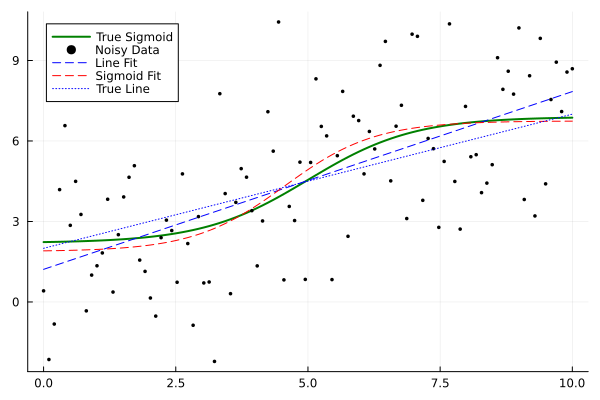

In [95]:
# Run the entire program with sigma (σ) input

run_program(σ=2.5)